In [17]:
import pandas as pd 
import numpy as np
import ast 
import os 
import re
import joblib

from Levenshtein import distance as levenshtein_distance
from rdkit import Chem
from mapchiral import mapchiral
import tmap as tm 
from rdkit import Chem
from rdkit.Chem import rdchem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

from faerun import Faerun
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams.update({'font.size': 10})

from eval_functions import *

## TMAP: COCONUT DB

#### Import data frame

Import dataset with training, validation and test data.

In [2]:
coconut_complete = pd.read_csv('data/coconut/coconut-complete-clean.csv')

Import dataset of structures removed because of incomplete stereocenter assignment.

In [3]:
coconut_incomplete = pd.read_csv('data/coconut/coconut-incomplete-clean.csv')
coconut_incomplete['split'] = 'incomplete'

Combine data frames for the full dataset with associated DOIs.

In [4]:
coconut_combined = pd.concat([coconut_complete, coconut_incomplete])

Check intersection

In [5]:
overlap = coconut_complete[coconut_complete['absolute_smiles'].isin(coconut_incomplete['absolute_smiles'])]
print(len(overlap))

5514


Clean chemical class

In [6]:
peptide = '[NX3,NX4+][CH1,CH2][CX3](=[OX1])[NX3,NX4+][CH1,CH2][CX3](=[OX1])[O,N]'
sugar = '[CR][OR][CHR]([OR0,NR0])[CR]'

def match_pattern(row, pattern, name):
    mol = Chem.MolFromSmiles(row['absolute_smiles'])
    if mol.HasSubstructMatch(Chem.MolFromSmarts(pattern)):
        return name 
    else:
        return row['chemical_class_new']

def clean_chemical_class(chemical_class): 
    if chemical_class == '"Lipids and lipid-like molecules"':
        return 'Lipids & Terpenes'
    elif chemical_class == '"Phenylpropanoids and polyketides"':
        return 'Polyketides'
    elif chemical_class == '"Alkaloids and derivatives"':
        return 'Alkaloids'
    elif chemical_class == '"Benzenoids"':
        return 'Benzenoids'
    elif chemical_class == 'Peptides':
        return 'Peptides'
    elif chemical_class == '"Lignans, neolignans and related compounds"':
        return 'Lignans'
    elif chemical_class == '"Nucleosides, nucleotides, and analogues"':
        return 'Nucleosides'
    elif chemical_class == 'Glycosides':
        return 'Glycosides'
    else:
        return 'Other'
    
coconut_complete['chemical_class_new'] = coconut_complete['chemical_super_class'].values.tolist()
coconut_complete['chemical_class_new'] = coconut_complete.apply(lambda x: match_pattern(x, sugar, 'Glycosides'), axis=1)
coconut_complete['chemical_class_new'] = coconut_complete.apply(lambda x: match_pattern(x, peptide, 'Peptides'), axis=1)
coconut_complete['chemical_class_new'] = coconut_complete['chemical_class_new'].apply(clean_chemical_class)

coconut_combined['chemical_class_new'] = coconut_combined['chemical_super_class'].values.tolist()
coconut_combined['chemical_class_new'] = coconut_combined.apply(lambda x: match_pattern(x, sugar, 'Glycosides'), axis=1)
coconut_combined['chemical_class_new'] = coconut_combined.apply(lambda x: match_pattern(x, peptide, 'Peptides'), axis=1)
coconut_combined['chemical_class_new'] = coconut_combined['chemical_class_new'].apply(clean_chemical_class)

Clean number of stereocenters

In [7]:
coconut_complete['num_stereocenters_new'] = coconut_complete['num_stereocenters'].apply(lambda x: x if x <= 10 else 11)
coconut_complete['num_stereoisomers_new'] = coconut_complete['num_stereoisomers'].apply(lambda x: x if x <= 10 else 11)

coconut_combined['num_stereocenters_new'] = coconut_combined['num_stereocenters'].apply(lambda x: x if x <= 10 else 11)
coconut_combined['num_stereoisomers_new'] = coconut_combined['num_stereoisomers'].apply(lambda x: x if x <= 10 else 11)

#### 3D bar plot

Stereoisomers vs. stereocenters for the full dataset.

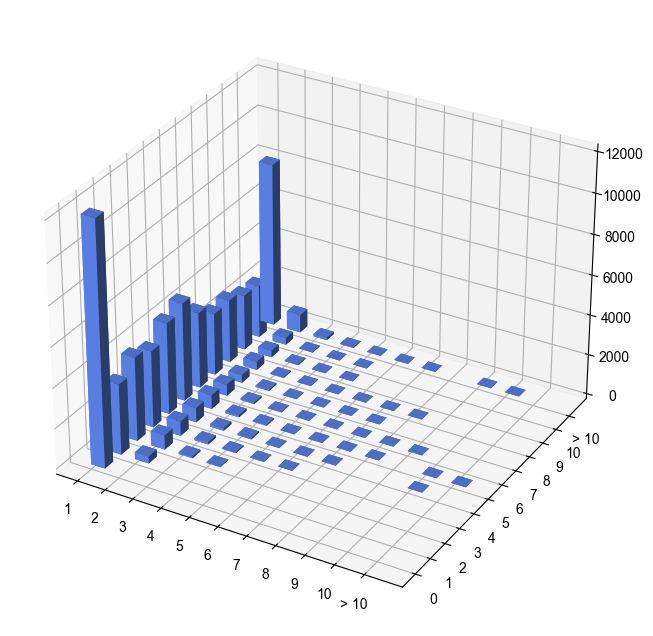

In [8]:
grouped = coconut_complete.groupby(['num_stereocenters_new', 'num_stereoisomers_new']).size().reset_index(name='counts')

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x = grouped['num_stereoisomers_new']
y = grouped['num_stereocenters_new']
z = grouped['counts']

dx = dy = 0.5  
dz = z

ax.bar3d(x, y, np.zeros_like(z), dx, dy, dz, shade=True, color='#648FFF')

ax.set_xticks(list(grouped['num_stereoisomers_new'].unique()))
ax.set_xticklabels([str(i) if i != 11 else '> 10' for i in grouped['num_stereoisomers_new'].unique()])

ax.set_yticks(list(grouped['num_stereocenters_new'].unique()))
ax.set_yticklabels([str(i) if i != 11 else '> 10' for i in grouped['num_stereocenters_new'].unique()])

plt.savefig('plots/3d_barplot_stereocenters_stereoisomers.png', dpi=1200)

Stereocenters vs. unassigned stereocenters for the incomplete dataset.

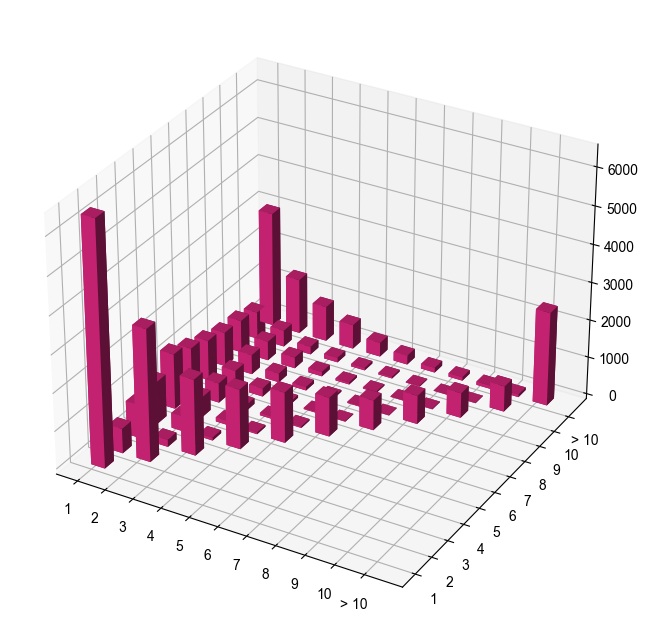

In [9]:
coconut_incomplete_flat = pd.read_csv('data/coconut/coconut-incomplete.csv')

coconut_incomplete_flat['num_stereocenters'] = coconut_incomplete_flat['num_stereocenters'].apply(lambda x: x if x <= 10 else 11)
coconut_incomplete_flat['num_unassigned'] = coconut_incomplete_flat['num_unassigned'].apply(lambda x: x if x <= 10 else 11)

grouped = coconut_incomplete_flat.groupby(['num_stereocenters', 'num_unassigned']).size().reset_index(name='counts')

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x = grouped['num_unassigned']
y = grouped['num_stereocenters']
z = grouped['counts']

dx = dy = 0.5  
dz = z

ax.bar3d(x, y, np.zeros_like(z), dx, dy, dz, shade=True, color='#DC267F')

ax.set_xticks(list(grouped['num_stereocenters'].unique()))
ax.set_xticklabels([str(i) if i != 11 else '> 10' for i in grouped['num_stereocenters'].unique()])

ax.set_yticks(list(grouped['num_unassigned'].unique()))
ax.set_yticklabels([str(i) if i != 11 else '> 10' for i in grouped['num_unassigned'].unique()])

plt.savefig('plots/3d_barplot_stereocenters_unassigned.png', dpi=1200)

Calculate MAP4C fingerprints for the full dataset.

In [10]:
coconut_combined['smiles'] = coconut_combined['smiles'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
coconut_combined['identifier'] = coconut_combined['identifier'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
coconut_combined_exploded = coconut_combined.explode('smiles').explode('identifier').drop_duplicates(subset=['smiles']).reset_index(drop=True)

In [11]:
if not os.path.exists('data/fingerprints/coconut_combined_map4c.joblib'):
    coconut_combined_exploded['map4c'] = coconut_combined_exploded['smiles'].apply(lambda x: mapchiral.encode(Chem.MolFromSmiles(x), max_radius=2, n_permutations=2048))
    joblib.dump(coconut_combined_exploded['map4c'], 'data/fingerprints/coconut_combined_map4c.joblib')
else:
    coconut_combined_exploded['map4c'] = joblib.load('data/fingerprints/coconut_combined_map4c.joblib')

#### Analysis of chirality distribution

Helper function

In [26]:
# -----------------------
# Peptide α-carbon helpers
# -----------------------
def _is_carbonyl_carbon(a: Chem.Atom) -> bool:
    if a.GetAtomicNum() != 6:
        return False
    for b in a.GetBonds():
        if b.GetBondType() == rdchem.BondType.DOUBLE:
            other = b.GetOtherAtom(a)
            if other.GetAtomicNum() == 8:  # C=O
                return True
    return False

def _is_alpha_carbon(a: Chem.Atom) -> bool:
    if a.GetAtomicNum() != 6:
        return False
    if a.GetChiralTag() == rdchem.ChiralType.CHI_UNSPECIFIED:
        return False
    nbrs = list(a.GetNeighbors())
    has_amide_N = any(n.GetAtomicNum() == 7 for n in nbrs)
    has_carbonyl = any(_is_carbonyl_carbon(n) for n in nbrs)
    return has_amide_N and has_carbonyl

def _is_cysteine_center(a: Chem.Atom) -> bool:
    amide_Ns = [n for n in a.GetNeighbors() if n.GetAtomicNum() == 7]
    carbonyl_Cs = [n for n in a.GetNeighbors() if _is_carbonyl_carbon(n)]
    backbone = set(amide_Ns + carbonyl_Cs)
    side = [n for n in a.GetNeighbors() if n not in backbone and n.GetAtomicNum() == 6]
    if not side:
        return False
    beta = side[0]
    return any(n.GetAtomicNum() == 16 for n in beta.GetNeighbors() if n.GetIdx() != a.GetIdx())

# -----------------------
# Counters (per SMILES)
# -----------------------
def count_RS(smiles: str):
    """Return (R_count, S_count) across ALL chiral atoms with CIP labels."""
    if not isinstance(smiles, str) or not smiles.strip():
        return (0, 0)
    m = Chem.MolFromSmiles(smiles.replace(" ", ""))
    if m is None:
        return (0, 0)
    Chem.AssignStereochemistry(m, cleanIt=True, force=True)
    R = S = 0
    for a in m.GetAtoms():
        if a.HasProp('_CIPCode'):
            cip = a.GetProp('_CIPCode')
            if cip == 'R': R += 1
            elif cip == 'S': S += 1
    return (R, S)

def count_LD(smiles: str):
    """Return (L_count, D_count) for peptide α-carbons only (Cys handled: L↔R, D↔S)."""
    if not isinstance(smiles, str) or not smiles.strip():
        return (0, 0)
    m = Chem.MolFromSmiles(smiles.replace(" ", ""))
    if m is None:
        return (0, 0)
    Chem.AssignStereochemistry(m, cleanIt=True, force=True)
    L = D = 0
    for a in m.GetAtoms():
        if not _is_alpha_carbon(a) or not a.HasProp('_CIPCode'):
            continue
        cip = a.GetProp('_CIPCode')
        if _is_cysteine_center(a):
            if cip == 'R': L += 1
            elif cip == 'S': D += 1
        else:
            if cip == 'S': L += 1
            elif cip == 'R': D += 1
    return (L, D)

def count_EZ(smiles: str):
    """Return (E_count, Z_count) for double bonds with assigned E/Z stereo."""
    if not isinstance(smiles, str) or not smiles.strip():
        return (0, 0)
    m = Chem.MolFromSmiles(smiles.replace(" ", ""))
    if m is None:
        return (0, 0)
    Chem.AssignStereochemistry(m, cleanIt=True, force=True)
    E = Z = 0
    for b in m.GetBonds():
        if b.GetBondType() == rdchem.BondType.DOUBLE:
            st = b.GetStereo()
            if st == rdchem.BondStereo.STEREOE:
                E += 1
            elif st == rdchem.BondStereo.STEREOZ:
                Z += 1
    return (E, Z)

def count_at_tokens(smiles: str):
    """Return (@_count, @@_count) where '@@' is not double-counted."""
    if not isinstance(smiles, str) or not smiles.strip():
        return (0, 0)
    s = smiles.replace(" ", "")
    double_at = len(re.findall(r'@@', s))
    single_at = len(re.findall(r'@(?!@)', s))
    return (single_at, double_at)

# ------------------------------------------
# Convenience: apply to any DataFrame column
# ------------------------------------------
def analyze_stereo(df: pd.DataFrame,
                   smiles_col: str,
                   add_per_row: bool = True,
                   return_copy: bool = True):
    """
    Analyze R/S atoms, L/D α-carbons, E/Z bonds, and @/@@ counts.

    Returns (df_result, summary_dict).
    """
    data = df.copy() if return_copy else df

    RS = df[smiles_col].astype(str).map(count_RS)
    LD = df[smiles_col].astype(str).map(count_LD)
    EZ = df[smiles_col].astype(str).map(count_EZ)
    AT = df[smiles_col].astype(str).map(count_at_tokens)

    if add_per_row:
        data["R_centers"],  data["S_centers"]  = zip(*RS)
        data["L_centers"],  data["D_centers"]  = zip(*LD)
        data["E_bonds"],    data["Z_bonds"]    = zip(*EZ)
        data["at_count"],   data["att_count"]  = zip(*AT)

    # Totals
    R_total  = sum(r for r, _ in RS)
    S_total  = sum(s for _, s in RS)
    L_total  = sum(l for l, _ in LD)
    D_total  = sum(d for _, d in LD)
    E_total  = sum(e for e, _ in EZ)
    Z_total  = sum(z for _, z in EZ)
    at_total = sum(a for a, _ in AT)
    att_total= sum(t for _, t in AT)

    def ratio(a, b):
        tot = a + b
        out = {"total_a": a, "total_b": b, "a_pct": 0.0, "b_pct": 0.0, "a_frac": 0.0, "b_frac": 0.0}
        if tot > 0:
            out.update({
                "a_pct": 100*a/tot, "b_pct": 100*b/tot,
                "a_frac": a/tot,    "b_frac": b/tot,
            })
        return out

    # Build summary without dict-union (compatible with Python < 3.9)
    summary = {
        "counts": {
            "R_total": R_total, "S_total": S_total,
            "L_total": L_total, "D_total": D_total,
            "E_total": E_total, "Z_total": Z_total,
            "@_total": at_total, "@@_total": att_total,
            "rows": len(df)
        }
    }

    rs = ratio(R_total, S_total); rs["labels"] = ("R", "S"); summary["RS"] = rs
    ld = ratio(L_total, D_total); ld["labels"] = ("L", "D"); summary["LD"] = ld
    ez = ratio(E_total, Z_total); ez["labels"] = ("E", "Z"); summary["EZ"] = ez
    at = ratio(at_total, att_total); at["labels"] = ("@", "@@"); summary["@/@@"] = at

    return data, summary

Full dataset

In [27]:
df2, summary = analyze_stereo(coconut_combined_exploded, smiles_col='smiles')
summary

{'counts': {'R_total': 268957,
  'S_total': 281653,
  'L_total': 30333,
  'D_total': 11137,
  'E_total': 37664,
  'Z_total': 17632,
  '@_total': 550917,
  '@@_total': 261256,
  'rows': 116403},
 'RS': {'total_a': 268957,
  'total_b': 281653,
  'a_pct': 48.847096856214016,
  'b_pct': 51.152903143785984,
  'a_frac': 0.4884709685621402,
  'b_frac': 0.5115290314378599,
  'labels': ('R', 'S')},
 'LD': {'total_a': 30333,
  'total_b': 11137,
  'a_pct': 73.14444176513142,
  'b_pct': 26.855558234868578,
  'a_frac': 0.7314444176513142,
  'b_frac': 0.2685555823486858,
  'labels': ('L', 'D')},
 'EZ': {'total_a': 37664,
  'total_b': 17632,
  'a_pct': 68.11342592592592,
  'b_pct': 31.886574074074073,
  'a_frac': 0.6811342592592593,
  'b_frac': 0.31886574074074076,
  'labels': ('E', 'Z')},
 '@/@@': {'total_a': 550917,
  'total_b': 261256,
  'a_pct': 67.83246919067736,
  'b_pct': 32.16753080932264,
  'a_frac': 0.6783246919067736,
  'b_frac': 0.3216753080932264,
  'labels': ('@', '@@')}}

Reorder to have splits mixed for homogeneous display on the TMAP plot.

In [12]:
coconut_combined_shuffled = coconut_combined_exploded.sample(frac=1, random_state=42).reset_index(drop=True)
coconut_combined_shuffled['split'].fillna(inplace=True, value='complete')

#### TMAP

Generate layout

In [13]:
if not os.path.exists(f'plots/tmaps/layouts/coconut_combined_layout.pkl'):
    
    lf = tm.LSHForest(2048, 32)

    map4 = np.array(coconut_combined_shuffled['map4c'])
    fps = []

    for i in map4:
        vec = tm.VectorUint(i)
        fps.append(vec)

    lf.batch_add(fps)
    lf.index()

    cfg = tm.LayoutConfiguration() #configuration parameters for tmap layout
    cfg.node_size = 1/32.5 #size of nodes which affects the magnitude of their repelling force. Decreasing this values generally resolves overlaps in a very crowded tree
    cfg.mmm_repeats = 2 #number of repeats of the per-level layout algorithm
    cfg.sl_extra_scaling_steps = 5 #sets the number of repeats of the scaling
    cfg.k = 20 #number of nearest neighbours used to create the k-nearest neighbour graph
    cfg.sl_scaling_type = tm.RelativeToAvgLength #Defines the relative scale of the graph
    x, y, s, t, _ = tm.layout_from_lsh_forest(lf, cfg)
    tm_layout = {'x': list(x), 'y': list(y), 's': list(s), 't': list(t)}
    joblib.dump(tm_layout, f'plots/tmaps/layouts/coconut_combined_layout.pkl')
else:
    tm_layout = joblib.load(f'plots/tmaps/layouts/coconut_combined_layout.pkl')

Interactive

In [15]:
category_labels, category_data = Faerun.create_categories(coconut_combined_shuffled['chemical_class_new'])
nstereo_labels, nstereo_data = Faerun.create_categories(coconut_combined_shuffled['num_stereocenters_new'])
split_labels, split_data = Faerun.create_categories(coconut_combined_shuffled['split'])

category_colors = {'Benzenoids': '#648FFF', 'Nucleosides': '#785EF0', 'Alkaloids': '#DC267F', 'Lignans': '#FE6100', 'Polyketides': '#2CA02C', 'Lipids & Terpenes': '#FFB000', 'Glycosides': '#8F2D56', 'Peptides': '#33A1C9', 'Other': '#B3B3B3'}
nstereo_colors = {0: '#D6D6D6', 1: '#648FFF', 2: '#6D79F8', 3: '#7663F2', 4: '#994BCA', 5: '#C63298', 6: '#E43363', 7: '#F34D2A', 8: '#FE6A00', 9: '#FF8D00', 10: '#FFB000', 11: '#FFDD00'}
split_colors = {'complete': '#D6D6D6', 'incomplete': '#FFB000'}

category_ordered = [category_colors[i] for i in sorted(category_colors.keys())]
nstereo_ordered = [nstereo_colors[i] for i in sorted(nstereo_colors.keys())]
split_ordered = [split_colors[i] for i in sorted(split_colors.keys())]

category_cmap = ListedColormap(category_ordered)
nstereo_cmap = ListedColormap(nstereo_ordered)
split_cmap = ListedColormap(split_ordered)

labels = []
for i, row in coconut_combined_shuffled.iterrows():
    labels.append(
            row['smiles']
            + '__'
            + '<small style="color:grey;">Link to COCONUT entry</small>'
            + '__'
            + f'<a target="_blank" href="https://coconut.naturalproducts.net/compounds/{row["identifier"]}">Go to COCONUT</a><br>'
        )

f = Faerun(
    view="front", 
    coords=False,
    title="",
    clear_color='#FFFFFF',
)

f.add_scatter(
    "MAP4_TMAP",
    {
        "x": tm.VectorFloat(tm_layout['x']),
        "y": tm.VectorFloat(tm_layout['y'] ),
        "c": [
            category_data,
            nstereo_data,
            split_data,
            ], 
        "labels": labels,
    },
    shader="smoothCircle",
    point_scale=2,
    max_point_size=20,
    legend_labels=[category_labels, nstereo_labels, split_labels],
    categorical=[True],
    colormap=[category_cmap, nstereo_cmap, split_cmap],
    series_title=['Chemical Superclass', 'Number of Stereocenters', 'Split'],
    has_legend=True,
)

f.thumbnail_width = 500

f.add_tree("MAP4_TMAP_tree", {"from": tm.VectorUint(tm_layout['s']), "to": tm.VectorUint(tm_layout['t'])}, point_helper="MAP4_TMAP")
f.plot('plots/tmaps/interactive', template='smiles')

/home/markus/Developer/Code/NPstereo/plots/tmaps/interactive.html

TMAP: number of stereocenters

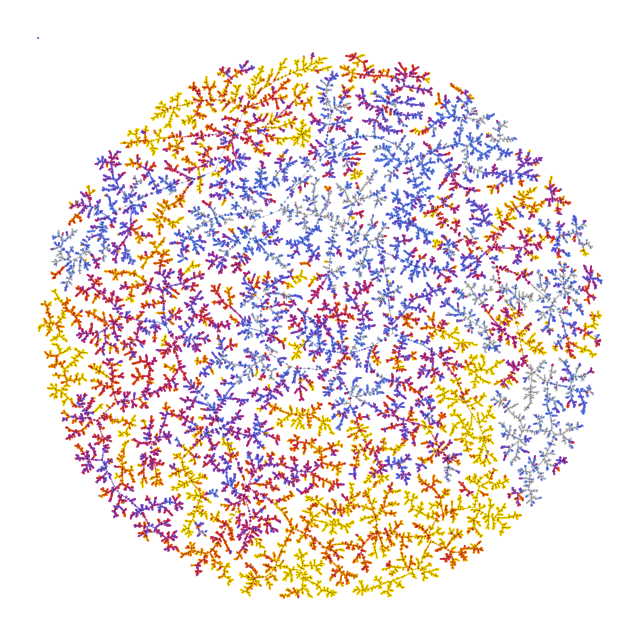

In [15]:
nstereo_colors = {0: '#D6D6D6', 1: '#648FFF', 2: '#6D79F8', 3: '#7663F2', 4: '#994BCA', 5: '#C63298', 6: '#E43363', 7: '#F34D2A', 8: '#FE6A00', 9: '#FF8D00', 10: '#FFB000', 11: '#FFDD00'}
colors = coconut_combined_shuffled['num_stereocenters_new'].map(nstereo_colors)

x, y = tm_layout['x'], tm_layout['y']

plt.figure(figsize=(8, 8))
plt.scatter(x, y, s=0.1, c=colors)
for source, target in zip(tm_layout['s'], tm_layout['t']):
    plt.plot([x[source], x[target]], [y[source], y[target]], 'k-', linewidth=0.1)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

plt.savefig('plots/tmaps/coconut_nstereo.png', dpi=1200, bbox_inches='tight')

TMAP: splits

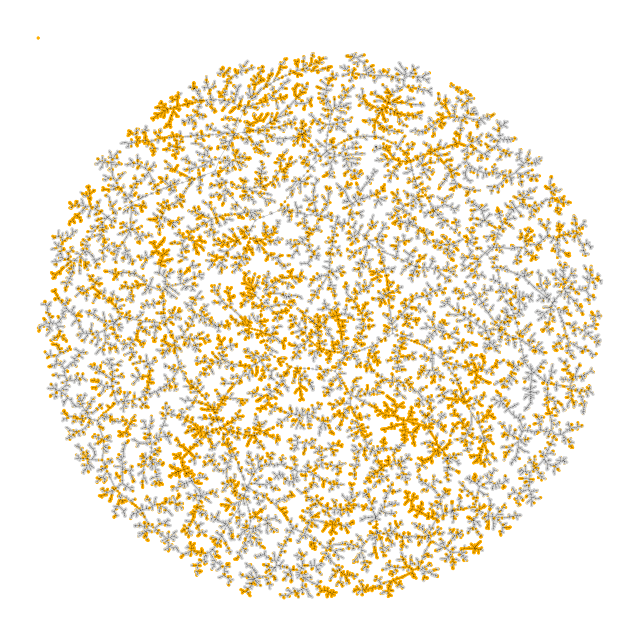

In [16]:
nstereo_colors = {'complete': '#D6D6D6', 'incomplete': '#FFB000'}
colors = coconut_combined_shuffled['split'].map(nstereo_colors)

x, y = tm_layout['x'], tm_layout['y']

plt.figure(figsize=(8, 8))
plt.scatter(x, y, s=1, c=colors)
for source, target in zip(tm_layout['s'], tm_layout['t']):
    plt.plot([x[source], x[target]], [y[source], y[target]], 'k-', linewidth=0.1)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

plt.savefig('plots/tmaps/coconut_splits.png', dpi=1200, bbox_inches='tight')

TMAP: chemical classes

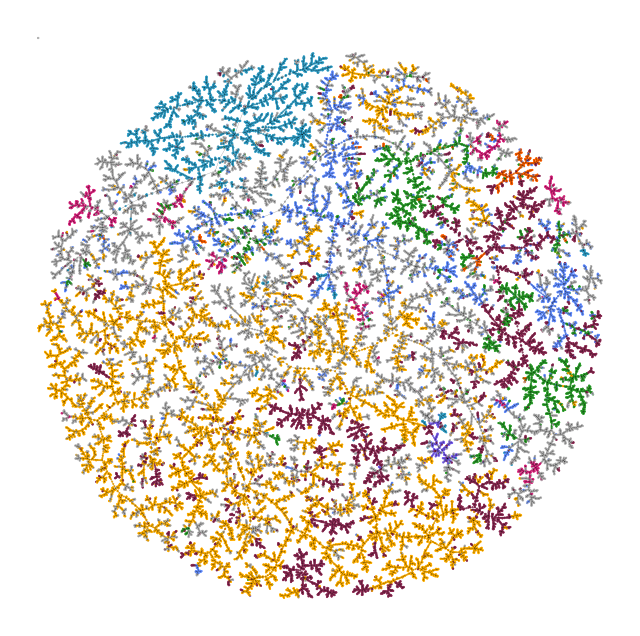

In [17]:
category_colors = {'Benzenoids': '#648FFF', 'Nucleosides': '#785EF0', 'Alkaloids': '#DC267F', 'Lignans': '#FE6100', 'Polyketides': '#2CA02C', 'Lipids & Terpenes': '#FFB000', 'Glycosides': '#8F2D56', 'Peptides': '#33A1C9', 'Other': '#B3B3B3'}
colors = coconut_combined_shuffled['chemical_class_new'].map(category_colors)

x, y = tm_layout['x'], tm_layout['y']

plt.figure(figsize=(8, 8))
plt.scatter(x, y, s=0.25, c=colors)
for source, target in zip(tm_layout['s'], tm_layout['t']):
    plt.plot([x[source], x[target]], [y[source], y[target]], 'k-', linewidth=0.1)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

plt.savefig('plots/tmaps/coconut_chemical_classes.png', dpi=1200, bbox_inches='tight')

## Prediction Analysis

Helper functions

In [20]:
SEEDS = [0, 1, 42]
MODELS = ["c1","r1","a2","a5","a10","a20","a50","npstereo","rp","m65"]
PARTIAL_MODELS = ["npstereo","rp","m65"]

def load_seed_df(model: str, seed: int, suffix: str, coconut_df: pd.DataFrame) -> pd.DataFrame:

    df = read_results(f'predictions/seed-{seed}/{model}-{suffix}/')

    df['num_stereocenters'] = df['source'].apply(add_stereocenters)
    df['num_unassigned']    = df['source'].apply(add_unassigned_stereocenters)

    df = add_chemical_class(df, coconut_df[['absolute_smiles','chemical_class_new']])

    if suffix.endswith('partial'):          
        df_acc = get_partial_accuracies(df)
    else:                                  
        df_acc = get_accuracies(df)
    
    results = unassigned_accuracies(df_acc)
 
    return results

def mean_over_seeds(model: str, suffix: str, coconut_df: pd.DataFrame) -> pd.DataFrame:

    results = [load_seed_df(model, s, suffix, coconut_df) for s in SEEDS]

    combined = pd.concat(results).groupby(level=0).mean().round(3)
    combined = combined.reindex(range(12))          
    return combined


aug_dfs, aug_rand_dfs = {}, {}

for model in MODELS:                                
    label = model.upper()                                  
    
    aug_dfs[label] = mean_over_seeds(model, 'canonical', coconut_complete)
    aug_rand_dfs[label] = mean_over_seeds(model, 'randomized', coconut_complete)

for model in PARTIAL_MODELS:                             
    label = model.upper()
    
    aug_dfs[label + ' PARTIAL'] = mean_over_seeds(model, 'canonical-partial', coconut_complete)
    aug_rand_dfs[label + ' PARTIAL'] = mean_over_seeds(model, 'randomized-partial', coconut_complete)

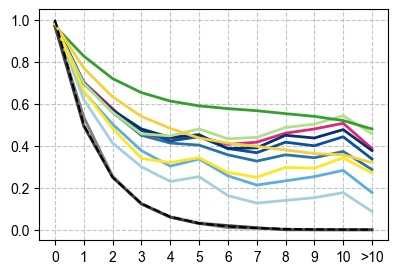

In [29]:
plt.figure(figsize=(4.5, 3))

colors = [
    "#DC2680",  # C1
    "#D9D9D9",  # R1
    "#A6CEE3",  # A2
    "#5DADE2",  # A5
    "#2874A6",  # A10
    "#08519C",  # A20
    "#08306B",  # A50
    "#B2DF8A",  # NPSTEREO
    "#7F7F7F",  # RP
    "#FDE725",  # M65
    "#33A02C",  # NPSTEREO PARTIAL
    "#404040",  # RP PARTIAL
    "#F4D03F",  # M65 PARTIAL
]


for (label, df), color in zip(aug_dfs.items(), colors):
    plt.plot(df.index, df['top1'], label=label, color=color, linewidth=2)

x = np.arange(0, 12)
y = 1/2**x
plt.plot(x, y, color='black', linestyle='--', label='Random')

plt.xticks(ticks=np.arange(12), labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, '>10'])
plt.grid(True, linestyle='--', alpha=0.75)
plt.savefig('plots/stereocenter_accuracies.png', dpi=1200, bbox_inches='tight')

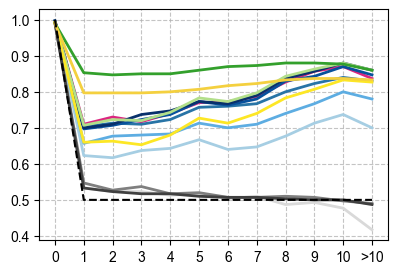

In [30]:
plt.figure(figsize=(4.5, 3))

colors = [
    "#DC2680",  # C1
    "#D9D9D9",  # R1
    "#A6CEE3",  # A2
    "#5DADE2",  # A5
    "#2874A6",  # A10
    "#08519C",  # A20
    "#08306B",  # A50
    "#B2DF8A",  # NPSTEREO
    "#7F7F7F",  # RP
    "#FDE725",  # M65
    "#33A02C",  # NPSTEREO PARTIAL
    "#404040",  # RP PARTIAL
    "#F4D03F",  # M65 PARTIAL
]

for (label, df), color in zip(aug_dfs.items(), colors):
    plt.plot(df.index, df['top1_wt'], label=label, color=color, linewidth=2)

x = np.arange(0, 12)
y = [1 if _ == 0 else 0.5 for _ in x]
plt.plot(x, y, color='black', linestyle='--', label='Random')

plt.xticks(ticks=np.arange(12), labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, '>10'])
plt.grid(True, linestyle='--', alpha=0.75)
plt.savefig('plots/stereocenter_accuracies_wt.png', dpi=1200, bbox_inches='tight')

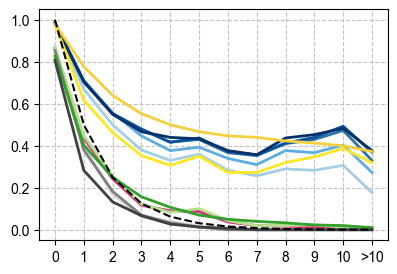

In [31]:
plt.figure(figsize=(4.5, 3))

colors = [
    "#DC2680",  # C1
    "#D9D9D9",  # R1
    "#A6CEE3",  # A2
    "#5DADE2",  # A5
    "#2874A6",  # A10
    "#08519C",  # A20
    "#08306B",  # A50
    "#B2DF8A",  # NPSTEREO
    "#7F7F7F",  # RP
    "#FDE725",  # M65
    "#33A02C",  # NPSTEREO PARTIAL
    "#404040",  # RP PARTIAL
    "#F4D03F",  # M65 PARTIAL
]

for (label, df), color in zip(aug_rand_dfs.items(), colors):
    plt.plot(df.index, df['top1'], label=label, color=color, linewidth=2)

x = np.arange(0, 12)
y = 1/2**x
plt.plot(x, y, color='black', linestyle='--', label='Random')

plt.xticks(ticks=np.arange(12), labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, '>10'])
plt.grid(True, linestyle='--', alpha=0.75)
plt.savefig('plots/stereocenter_accuracies_randomized.png', dpi=1200, bbox_inches='tight')

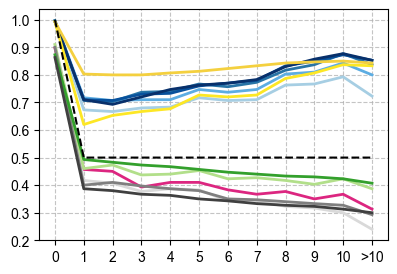

In [33]:
plt.figure(figsize=(4.5, 3))

colors = [
    "#DC2680",  # C1
    "#D9D9D9",  # R1
    "#A6CEE3",  # A2
    "#5DADE2",  # A5
    "#2874A6",  # A10
    "#08519C",  # A20
    "#08306B",  # A50
    "#B2DF8A",  # NPSTEREO
    "#7F7F7F",  # RP
    "#FDE725",  # M65
    "#33A02C",  # NPSTEREO PARTIAL
    "#404040",  # RP PARTIAL
    "#F4D03F",  # M65 PARTIAL
]

for (label, df), color in zip(aug_rand_dfs.items(), colors):
    plt.plot(df.index, df['top1_wt'], label=label, color=color, linewidth=2)

x = np.arange(0, 12)
y = [1 if _ == 0 else 0.5 for _ in x]
plt.plot(x, y, color='black', linestyle='--', label='Random')

plt.yticks(np.arange(0.2, 1.01, 0.1))

plt.xticks(ticks=np.arange(12), labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, '>10'])
plt.grid(True, linestyle='--', alpha=0.75)
plt.savefig('plots/stereocenter_accuracies_wt_randomized.png', dpi=1200, bbox_inches='tight')

Chemical class analysis

In [25]:
def load_class_seed_df(model: str, seed: int, suffix: str, coconut_df: pd.DataFrame) -> pd.DataFrame:

    df = read_results(f'predictions/seed-{seed}/{model}-{suffix}/')

    df['num_stereocenters'] = df['source'].apply(add_stereocenters)
    df['num_unassigned']    = df['source'].apply(add_unassigned_stereocenters)
    
    df = add_chemical_class(df, coconut_df[['absolute_smiles','chemical_class_new']])

    if suffix.endswith('partial'):          
        df_acc = get_partial_accuracies(df)
    else:                                  
        df_acc = get_accuracies(df)
    
    results = chemical_class_accuracies(df_acc)
 
    return results

def mean_over_seeds_class(model: str, suffix: str, coconut_df: pd.DataFrame) -> pd.DataFrame:
    results = [load_class_seed_df(model, s, suffix, coconut_df) for s in SEEDS]
    concat = pd.concat(results)
    
    means = concat.groupby(level=0).mean()
    stds  = concat.groupby(level=0).std()

    combined = means.round(2).astype(str) + " ± " + stds.round(2).astype(str)
    return combined


chemclass_dfs = {}

for model in MODELS:                                
    label = model.upper()                                  
    chemclass_dfs[label] = mean_over_seeds_class(model, 'canonical', coconut_complete)

for model in PARTIAL_MODELS:
    label = model.upper() + " PARTIAL"
    chemclass_dfs[label] = mean_over_seeds_class(model, 'canonical-partial', coconut_complete)

In [44]:
def fix_repeated_cell(val):
    match = re.search(r'\d+\.\d+\s±\s\d+\.\d+', val)
    return match.group(0) if match else val

chemclass_summary = pd.DataFrame({
    model: df["top1_wt"].apply(fix_repeated_cell)
    for model, df in chemclass_dfs.items()
}).T

chemclass_summary = chemclass_summary[sorted(chemclass_summary.columns)]
chemclass_summary.to_csv('results/chemclass_accuracy.csv')